In [37]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

<a name='2'></a>
## 2 - Problem Statement

Neural Style Transfer (NST) is one of the most fun and interesting optimization techniques in deep learning. It merges two images, namely: a <strong>"content" image (C)</strong> and a <strong>"style" image (S)</strong>, to create a <strong>"generated" image (G)</strong>. The generated image G combines the "content" of the image C with the "style" of image S. 

In this assignment, you are going to combine the Louvre museum in Paris (content image C) with the impressionist style of Claude Monet (content image S) to generate the following image:

<img src="images/louvre_generated.png" style="width:750px;height:200px;">

Let's get started!

In [38]:
tf.random.set_seed(272) # DO NOT CHANGE THIS VALUE
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


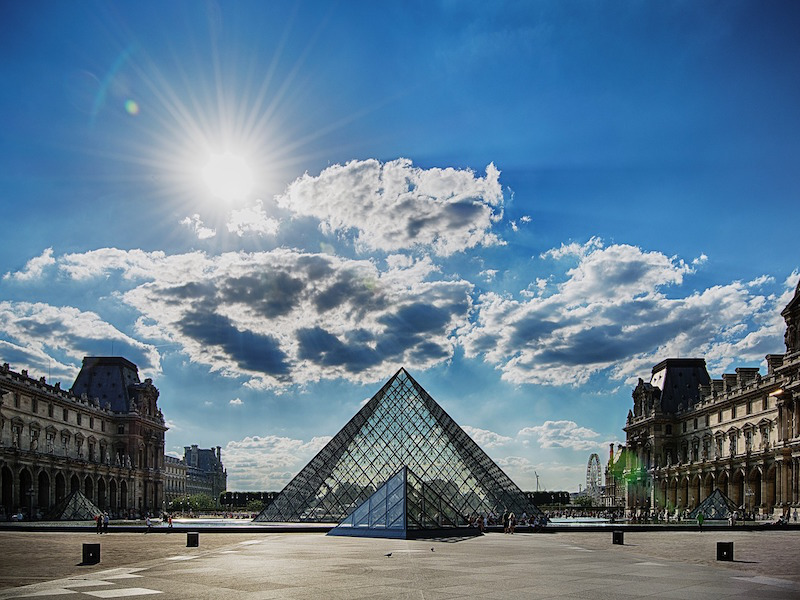

In [39]:
content_image = Image.open("images/louvre.jpg")
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

<a name='4-1-2'></a>
#### 4.1.2 - Content Cost Function $J_{content}(C,G)$
One goal you should aim for when performing NST is for the content in generated image G to match the content of image C. A method to achieve this is to calculate the content cost function, which will be defined as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. 
* For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 
* In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below.
* Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style cost $J_{style}$.

<img src="images/NST_LOSS.png" style="width:800px;height:400px;">

In [76]:
# UNQ_C1
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(content_output, generated_output):
    # Coding the content cost
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list() # Retrieve the dimensions (number of samples, height, width and no of channels)
    
    a_C_unrolled = tf.reshape(a_C,(m,n_H*n_W,n_C)) #Reshape as (samples, product of dimensions, channels)
    a_G_unrolled = tf.reshape(a_G,(m,n_H*n_W,n_C))
    
    # compute the cost with tensorflow (≈1 line)
    J_content =  (.25 / float(int(n_H * n_W * n_C))) * tf.reduce_sum(tf.square(a_G_unrolled-a_C_unrolled)) #The equation we were given
    
    ### END CODE HERE
    
    return J_content

In [77]:
tf.random.set_seed(1)
a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost([a_C], [a_G])
J_content_0 = compute_content_cost([a_C], [a_C])
assert type(J_content) == EagerTensor, "Use the tensorflow function"
assert np.isclose(J_content_0, 0.0), "Wrong value. compute_content_cost(A, A) must be 0"
assert np.isclose(J_content, 7.0568767), f"Wrong value. Expected {7.0568767},  current{J_content}"

print("J_content = " + str(J_content))

# Test that it works with symbolic tensors
ll = tf.keras.layers.Dense(8, activation='relu', input_shape=(1, 4, 4, 3))
model_tmp = tf.keras.models.Sequential()
model_tmp.add(ll)
try:
    compute_content_cost(ll.output, ll.output)
    print("\033[92mAll tests passed")
except Exception as inst:
    print("\n\033[91mDon't use the numpy API inside compute_content_cost\n")
    print(inst)

J_content = tf.Tensor(7.056877, shape=(), dtype=float32)
All tests passed


**Expected Output**:

<table>
    <tr>
        <td>
            <b>J_content</b>  
        </td>
        <td>
            7.0568767
        </td>
    </tr>

</table>


Congrats! You've now successfully calculated the content cost function!

<br>
<font color = 'blue'>
    
**What you should remember:**
    
- The content cost takes a hidden layer activation of the neural network, and measures how different $a^{(C)}$ and $a^{(G)}$ are. 
- When you minimize the content cost later, this will help make sure $G$ has similar content as $C$. 


<a name='4-2'></a>
### 4.2 - Computing the Style Cost

For the running example, you will use the following style image: 

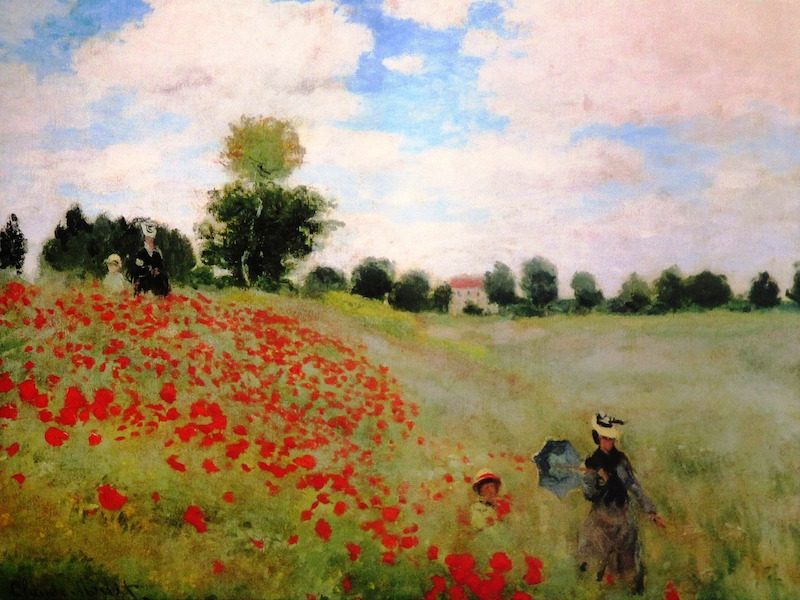

In [42]:
example = Image.open("images/monet_800600.jpg")
example

This was painted in the style of <b>[impressionism](https://en.wikipedia.org/wiki/Impressionism)</b>.

Now let's see how you can now define a "style" cost function $J_{style}(S,G)$!


#### Compute Gram matrix $G_{gram}$
You will compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:

<img src="images/NST_GM.png" style="width:900px;height:300px;">

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)ij}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### $G_{(gram),ii}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 


By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image. 

<a name='ex-2'></a>
### Exercise 2 - gram_matrix
* Using TensorFlow, implement a function that computes the Gram matrix of a matrix A. 
    * The formula is: The gram matrix of A is $G_A = AA^T$. 
* You may want to use these functions: [matmul](https://www.tensorflow.org/api_docs/python/tf/matmul) and [transpose](https://www.tensorflow.org/api_docs/python/tf/transpose).

In [43]:
# UNQ_C2
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    #For style matrix, we need to calculate the matrix product across channels
    ### START CODE HERE
    #(≈1 line)
    
    GA = tf.linalg.matmul(A,tf.transpose(A))
    
    ### END CODE HERE

    return GA

In [44]:
tf.random.set_seed(1)
A = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
GA = gram_matrix(A)

assert type(GA) == EagerTensor, "Use the tensorflow function"
assert GA.shape == (3, 3), "Wrong shape. Check the order of the matmul parameters"
assert np.allclose(GA[0,:], [63.1888, -26.721275, -7.7320204]), "Wrong values."

print("GA = \n" + str(GA))

print("\033[92mAll tests passed")

GA = 
tf.Tensor(
[[ 63.1888    -26.721275   -7.7320204]
 [-26.721275   12.76758    -2.5158243]
 [ -7.7320204  -2.5158243  23.752384 ]], shape=(3, 3), dtype=float32)
All tests passed


**Expected Output**:

<table>
    <tr>
        <td>
            <b>GA</b>
        </td>
        <td>
           [[ 63.1888    -26.721275   -7.7320204] <br>
 [-26.721275   12.76758    -2.5158243] <br>
 [ -7.7320204  -2.5158243  23.752384 ]] <br>
        </td>
    </tr>

</table>

<a name='4-2-2'></a>
#### 4.2.2 - Style Cost

You now know how to calculate the Gram matrix. Congrats! Your next goal will be to minimize the distance between the Gram matrix of the "style" image S and the Gram matrix of the "generated" image G. 
* For now, you will use only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.
* Make sure you remember that this cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$


<a name='ex-3'></a>
### Exercise 3 - compute_layer_style_cost
Compute the style cost for a single layer. 

**Instructions**: The 3 steps to implement this function are:
1. Retrieve dimensions from the hidden layer activations a_G: 
    - To retrieve dimensions from a tensor X, use: `X.get_shape().as_list()`
2. Unroll the hidden layer activations a_S and a_G into 2D matrices, as explained in the picture above (see the images in the sections "computing the content cost" and "style matrix").
    - You may use [tf.transpose](https://www.tensorflow.org/api_docs/python/tf/transpose) and [tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape).
3. Compute the Style matrix of the images S and G. (Use the function you had previously written.) 
4. Compute the Style cost:
    - You may find [tf.reduce_sum](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [tf.square](https://www.tensorflow.org/api_docs/python/tf/square) and [tf.subtract](https://www.tensorflow.org/api_docs/python/tf/subtract) useful.
    
    
#### Additional Hints
* Since the activation dimensions are $(m, n_H, n_W, n_C)$ whereas the desired unrolled matrix shape is $(n_C, n_H*n_W)$, the order of the filter dimension $n_C$ is changed.  So `tf.transpose` can be used to change the order of the filter dimension.


In [45]:
# UNQ_C3
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    ### START CODE HERE
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    print(tf.shape(a_S))
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape(a_S,[n_H*n_W,n_C])
    a_G = tf.reshape(a_G,[n_H*n_W,n_C])
    print(tf.shape(a_S))
    a_S=tf.transpose(a_S)
    a_G=tf.transpose(a_G)
    print(tf.shape(a_S))


    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    # Computing the loss (≈1 line)
    J_style_layer = ((.5 / (n_H * n_W * n_C)) ** 2) * tf.reduce_sum(tf.square(GS-GG)) #Equation given above
    
    ### END CODE HERE
    
    return J_style_layer

In [46]:
tf.random.set_seed(1)
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_style_layer_GG = compute_layer_style_cost(a_G, a_G)
J_style_layer_SG = compute_layer_style_cost(a_S, a_G)


assert type(J_style_layer_GG) == EagerTensor, "Use the tensorflow functions"
assert np.isclose(J_style_layer_GG, 0.0), "Wrong value. compute_layer_style_cost(A, A) must be 0"
assert J_style_layer_SG > 0, "Wrong value. compute_layer_style_cost(A, B) must be greater than 0 if A != B"
assert np.isclose(J_style_layer_SG, 14.017805), "Wrong value."

print("J_style_layer = " + str(J_style_layer_SG))

# Test that it works with symbolic tensors
ll = tf.keras.layers.Dense(8, activation='relu', input_shape=(4, 4, 3))
model_tmp = tf.keras.models.Sequential()
model_tmp.add(ll)
try:
    compute_layer_style_cost(ll.output, ll.output)
    print("\033[92mAll tests passed")
except Exception as inst:
    print("\n\033[91mDon't use the numpy API inside compute_layer_style_cost\n")
    print(inst)

tf.Tensor([1 4 4 3], shape=(4,), dtype=int32)
tf.Tensor([16  3], shape=(2,), dtype=int32)
tf.Tensor([ 3 16], shape=(2,), dtype=int32)
tf.Tensor([1 4 4 3], shape=(4,), dtype=int32)
tf.Tensor([16  3], shape=(2,), dtype=int32)
tf.Tensor([ 3 16], shape=(2,), dtype=int32)
J_style_layer = tf.Tensor(14.017805, shape=(), dtype=float32)
Tensor("Shape_3:0", shape=(4,), dtype=int32)
Tensor("Shape_4:0", shape=(2,), dtype=int32)
Tensor("Shape_5:0", shape=(2,), dtype=int32)
All tests passed


**Expected Output**:

<table>
    <tr>
        <td>
            <b>J_style_layer</b>
        </td>
        <td>
           14.017805
        </td>
    </tr>

</table>

<a name='4-2-3'></a>
#### 4.2.3 Style Weights

* So far you have captured the style from only one layer. 
* You'll get better results if you "merge" style costs from several different layers. 
* Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
* After completing this exercise, feel free to come back and experiment with different weights to see how it changes the generated image $G$.
* By default, give each layer equal weight, and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

Start by listing the layer names:

In [47]:
for layer in vgg.layers:
    print(layer.name)

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Get a look at the output of a layer `block5_conv4`. You will later define this as the content layer, which will represent the image.

In [48]:
vgg.get_layer('block5_conv4').output

<tf.Tensor 'block5_conv4/Relu_2:0' shape=(None, 25, 25, 512) dtype=float32>

Now choose layers to represent the style of the image and assign style costs:

In [49]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


In [50]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    # Use the pre comupted values
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not to be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the array contains the content layer image, which must not to be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  #Across the number of layers and channels
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

<a name='4-3'></a>
### 4.3 - Defining the Total Cost to Optimize

Finally, you will create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

<a name='ex-5'></a>
### Exercise 5 - total_cost

Implement the total cost function which includes both the content cost and the style cost. 

In [51]:
# UNQ_C4
# GRADED FUNCTION: total_cost
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    ### START CODE HERE
    
    #(≈1 line)
    J = (alpha*J_content)+(beta*J_style)
    
    ### START CODE HERE

    return J

In [52]:
J_content = 0.2    
J_style = 0.8
J = total_cost(J_content, J_style)

assert type(J) == EagerTensor, "Do not remove the @tf.function() modifier from the function"
assert J == 34, "Wrong value. Try inverting the order of alpha and beta in the J calculation"
assert np.isclose(total_cost(0.3, 0.5, 3, 8), 4.9), "Wrong value. Use the alpha and beta parameters"

np.random.seed(1)
print("J = " + str(total_cost(np.random.uniform(0, 1), np.random.uniform(0, 1))))

print("\033[92mAll tests passed")

J = tf.Tensor(32.9832, shape=(), dtype=float32)
All tests passed


**Expected Output**:

<table>
    <tr>
        <td>
            <b>J</b>
        </td>
        <td>
           32.9832
        </td>
    </tr>

</table>

<font color = 'blue'>
    
**What you should remember:**
- The total cost is a linear combination of the content cost $J_{content}(C,G)$ and the style cost $J_{style}(S,G)$.
- $\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style.

(1, 400, 400, 3)


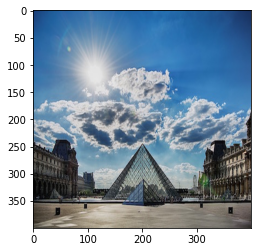

In [53]:
content_image = np.array(Image.open("images/louvre_small.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


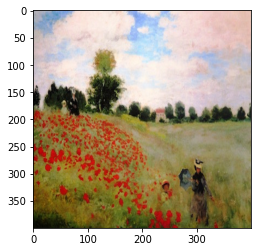

In [54]:
style_image =  np.array(Image.open("images/monet.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


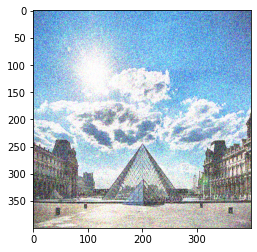

In [55]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.5)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [56]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [57]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [58]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

In [59]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input.
a_G = vgg_model_outputs(generated_image)

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

print(J_content)

tf.Tensor(0.008070096, shape=(), dtype=float32)


In [60]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

# Compute the style cost
J_style = compute_style_cost(a_S, a_G)
print(J_style)

tf.Tensor([  1 400 400  64], shape=(4,), dtype=int32)
tf.Tensor([160000     64], shape=(2,), dtype=int32)
tf.Tensor([    64 160000], shape=(2,), dtype=int32)
tf.Tensor([  1 200 200 128], shape=(4,), dtype=int32)
tf.Tensor([40000   128], shape=(2,), dtype=int32)
tf.Tensor([  128 40000], shape=(2,), dtype=int32)
tf.Tensor([  1 100 100 256], shape=(4,), dtype=int32)
tf.Tensor([10000   256], shape=(2,), dtype=int32)
tf.Tensor([  256 10000], shape=(2,), dtype=int32)
tf.Tensor([  1  50  50 512], shape=(4,), dtype=int32)
tf.Tensor([2500  512], shape=(2,), dtype=int32)
tf.Tensor([ 512 2500], shape=(2,), dtype=int32)
tf.Tensor([  1  25  25 512], shape=(4,), dtype=int32)
tf.Tensor([625 512], shape=(2,), dtype=int32)
tf.Tensor([512 625], shape=(2,), dtype=int32)
tf.Tensor(598.82825, shape=(), dtype=float32)


In [61]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [68]:
# UNQ_C5
# GRADED FUNCTION: train_step

optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        # Compute a_G as the vgg_model_outputs for the current generated image
        
        ### START CODE HERE
        
        #(1 line)
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        #(1 line)
        J_style = compute_style_cost(a_S,a_G)

        #(2 lines)
        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style)  
        
        ### END CODE HERE
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J

In [69]:
# You always must run the last cell before this one. You will get an error if not.
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

J1 = train_step(generated_image)
print(J1)
assert type(J1) == EagerTensor, f"Wrong type {type(J1)} != {EagerTensor}"
assert np.isclose(J1, 10221.168), f"Unexpected cost for epoch 0: {J1} != {10221.168}"

J2 = train_step(generated_image)
print(J2)
assert np.isclose(J2, 6081.23541, rtol=0.05), f"Unexpected cost for epoch 1: {J2} != {6081.2354}"

print("\033[92mAll tests passed")

Tensor("Shape:0", shape=(4,), dtype=int32)
Tensor("Shape_1:0", shape=(2,), dtype=int32)
Tensor("Shape_2:0", shape=(2,), dtype=int32)
Tensor("Shape_3:0", shape=(4,), dtype=int32)
Tensor("Shape_4:0", shape=(2,), dtype=int32)
Tensor("Shape_5:0", shape=(2,), dtype=int32)
Tensor("Shape_6:0", shape=(4,), dtype=int32)
Tensor("Shape_7:0", shape=(2,), dtype=int32)
Tensor("Shape_8:0", shape=(2,), dtype=int32)
Tensor("Shape_9:0", shape=(4,), dtype=int32)
Tensor("Shape_10:0", shape=(2,), dtype=int32)
Tensor("Shape_11:0", shape=(2,), dtype=int32)
Tensor("Shape_12:0", shape=(4,), dtype=int32)
Tensor("Shape_13:0", shape=(2,), dtype=int32)
Tensor("Shape_14:0", shape=(2,), dtype=int32)
Tensor("Shape:0", shape=(4,), dtype=int32)
Tensor("Shape_1:0", shape=(2,), dtype=int32)
Tensor("Shape_2:0", shape=(2,), dtype=int32)
Tensor("Shape_3:0", shape=(4,), dtype=int32)
Tensor("Shape_4:0", shape=(2,), dtype=int32)
Tensor("Shape_5:0", shape=(2,), dtype=int32)
Tensor("Shape_6:0", shape=(4,), dtype=int32)
Tensor("S

**Expected output**
```
tf.Tensor(10221.169, shape=(), dtype=float32)
tf.Tensor(6081.1763, shape=(), dtype=float32)
```

Looks like it's working! Now you'll get to put it all together into one function to better see your results!

<a name='5-6'></a>
### 5.6 - Train the Model

Run the following cell to generate an artistic image. It should take about 3min on a GPU for 2500 iterations. Neural Style Transfer is generally trained using GPUs.

If you increase the learning rate you can speed up the style transfer, but often at the cost of quality.

Epoch 0 


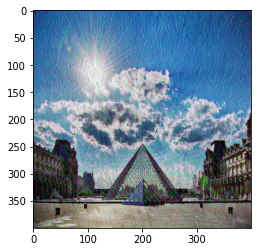

Epoch 250 


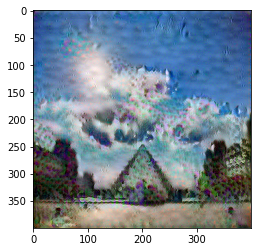

Epoch 500 


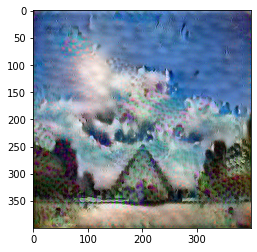

Epoch 750 


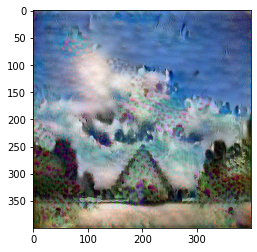

Epoch 1000 


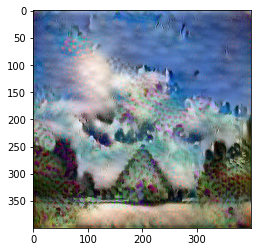

Epoch 1250 


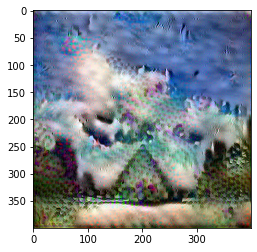

Epoch 1500 


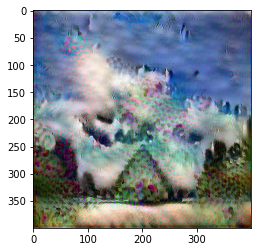

Epoch 1750 


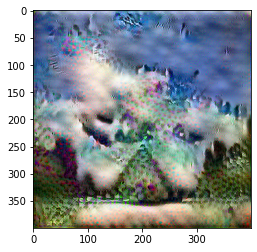

Epoch 2000 


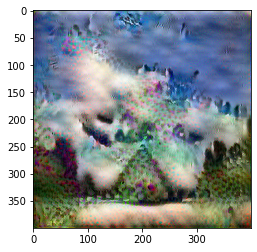

Epoch 2250 


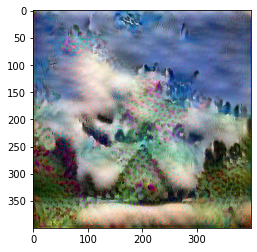

Epoch 2500 


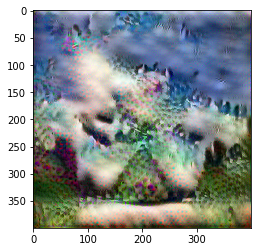

In [70]:
# Show the generated image at some epochs
# Uncoment to reset the style transfer process. You will need to compile the train_step function again 
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show() 

Now, run the following code cell to see the results!

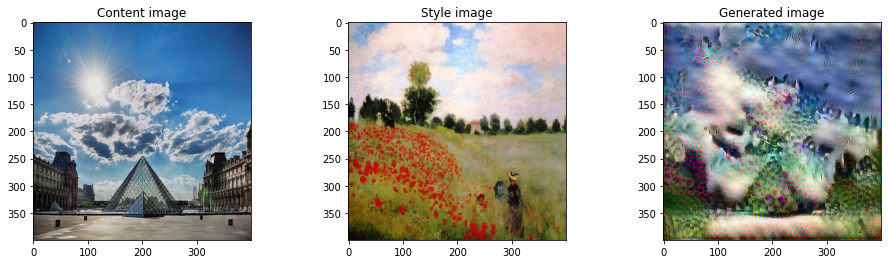

In [71]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

Look at that! You did it! After running this, in the upper bar of the notebook click on "File" and then "Open". Go to the "/output" directory to see all the saved images. Open "generated_image" to see the generated image! :)

Running for around 20000 epochs with a learning rate of 0.001, you should see something like the image presented below on the right:

<img src="images/louvre_generated.png" style="width:800px;height:300px;">

The hyperparameters were set so that you didn't have to wait too long to see an initial result. To get the best looking results, you may want to try running the optimization algorithm longer (and perhaps with a smaller learning rate). After completing and submitting this assignment, come back and play more with this notebook, and see if you can generate even better looking images. But first, give yourself a pat on the back for finishing this long assignment!

Here are few other examples:

- The beautiful ruins of the ancient city of Persepolis (Iran) with the style of Van Gogh (The Starry Night)
<img src="images/perspolis_vangogh.png" style="width:750px;height:300px;">

- The tomb of Cyrus the great in Pasargadae with the style of a Ceramic Kashi from Ispahan.
<img src="images/pasargad_kashi.png" style="width:750px;height:300px;">

- A scientific study of a turbulent fluid with the style of a abstract blue fluid painting.
<img src="images/circle_abstract.png" style="width:750px;height:300px;">